 Text spam model code

In [1]:
# -*- coding:UTF-8 -*-
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''
#-*- coding:utf-8 -*-
from __future__ import print_function
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Dropout, GRU
from keras.models import Model
from keras.optimizers import RMSprop,SGD
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,recall_score
from sklearn.metrics import roc_curve,auc
from keras.models import Sequential
from keras.layers import  Flatten,BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction =1
config.gpu_options.allow_growth = True 
sess = tf.Session(config = config)


BASE_DIR = '/home/aqts/yangHong/first-spam-experiment/'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
# Read the text dataset path
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'data/text_email_dataset/')
print(TEXT_DATA_DIR)
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 200

nb_filters = 256
hiden_lstm_layer = 256

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {'ham':0, 'spam':1}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
                        
count = 0
for folder in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, folder)
    for fname in sorted(os.listdir(path)):
        if fname is not None:
            fpath = os.path.join(path, fname)
            args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
            with open(fpath, **args) as f:
                t = f.read()
                i = t.find('Subject:')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                count+=1
                print(count,":",t[0:30])
            if folder =='ham':
                labels.append(0)
                print('ham')
            else:
                labels.append(1)
                print('spam')
# print('Process text dataset done')
# print('count:',count)


Using TensorFlow backend.


/home/aqts/yangHong/first-spam-experiment/data/text_email_dataset/
Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
1 : Subject: re : quasi
good morni
ham
2 : Subject: enrononline desk to d
ham
3 : Subject: david gray
bill ,
is 
ham
4 : Subject: re : monday blues
goo
ham
5 : Subject: monday blues
bill ,
i
ham
6 : Subject: wednesday enpower cle
ham
7 : Subject: next wednesday ' s in
ham
8 : Subject: re : weights ? nice .
ham
9 : Subject: re : weights ? nice .
ham
10 : Subject: yummy frappachino
hey
ham
11 : Subject: re : no java ?
you ar
ham
12 : Subject: no java ?
bill ,
how 
ham
13 : Subject: volleyball
we are in 
ham
14 : Subject: celebrate responsibly
ham
15 : Subject: ncpa br is back
hey g
ham
16 : Subject: dave porter
was dave 
ham
17 : Subject: vacation payback
leaf
ham
18 : Subject: drug test
bill -
as i
ham
19 : Subject: out of office
i will 
ham
20 : Subject: data at your fingerti
ham
21 : Subject: 2001 summer assessmen
ham
22 : Subject: quarterly new 

294 : Subject: palo verde schedules 
ham
295 : Subject: vacation request
gree
ham
296 : Subject: hourly sheet
bill , i
ham
297 : Subject: out of office ( jury 
ham
298 : Subject: re : more questions -
ham
299 : Subject: iso compliance filing
ham
300 : Subject: re : goodday ' captai
ham
301 : Subject: fyi
i left kathy a me
ham
302 : Subject: si server will be una
ham
303 : Subject: i ' m in june 01 trad
ham
304 : Subject: employment law course
ham
305 : Subject: deals for 7 / 12 / 01
ham
306 : Subject: summary - judge ' s r
ham
307 : Subject: * information only * 
ham
308 : Subject: fw : annuities for de
ham
309 : Subject: delano unit outage 7 
ham
310 : Subject: buy - back strategy
g
ham
311 : Subject: please come share bir
ham
312 : Subject: fw : annuities for de
ham
313 : Subject: wapa cut on 6 - 2 - 0
ham
314 : Subject: would you like free t
ham
315 : Subject: baby announcement
chr
ham
316 : Subject: eol data , july 13 , 
ham
317 : Subject: delano energy
group ,
ham
318 : Subject: r

566 : Subject: caiso notification : 
ham
567 : Subject: re : real time sheet 
ham
568 : Subject: fw : e - request 5359
ham
569 : Subject: real - time short for
ham
570 : Subject: august & september sc
ham
571 : Subject: elm course offering
e
ham
572 : Subject: reminder / last chanc
ham
573 : Subject: pdci derate for 8 / 2
ham
574 : Subject: ethink about it : 08 
ham
575 : Subject: the negotiation skill
ham
576 : Subject: beep normal ( unsplit
ham
577 : Subject: delano energy
group ,
ham
578 : Subject: harbor cogen
group ,

ham
579 : Subject: request submitted : a
ham
580 : Subject: path 26
path 26 n - s
ham
581 : Subject: out
i wanted to send 
ham
582 : Subject: re : copper
mark than
ham
583 : Subject: i think we need to ha
ham
584 : Subject: re :
well , he ' s st
ham
585 : Subject: monitor
your monitor 
ham
586 : Subject: fw : us west power po
ham
587 : Subject: hey ,
do you know wha
ham
588 : Subject: formation of enron ma
ham
589 : Subject: cozy relationship bet
ham
590 : Subject: a

837 : Subject: start date : 12 / 20 
ham
838 : Subject: start date : 12 / 20 
ham
839 : Subject: start date : 12 / 20 
ham
840 : Subject: start date : 12 / 20 
ham
841 : Subject: start date : 12 / 20 
ham
842 : Subject: start date : 12 / 20 
ham
843 : Subject: start date : 12 / 19 
ham
844 : Subject: start date : 12 / 19 
ham
845 : Subject: start date : 12 / 21 
ham
846 : Subject: schedule crawler : ho
ham
847 : Subject: start date : 12 / 21 
ham
848 : Subject: start date : 12 / 21 
ham
849 : Subject: start date : 12 / 21 
ham
850 : Subject: start date : 12 / 21 
ham
851 : Subject: start date : 12 / 21 
ham
852 : Subject: start date : 12 / 21 
ham
853 : Subject: start date : 12 / 21 
ham
854 : Subject: start date : 12 / 21 
ham
855 : Subject: start date : 12 / 21 
ham
856 : Subject: start date : 12 / 21 
ham
857 : Subject: start date : 12 / 21 
ham
858 : Subject: start date : 12 / 20 
ham
859 : Subject: schedule crawler : ho
ham
860 : Subject: start date : 12 / 22 
ham
861 : Subject: s

1127 : Subject: start date : 1 / 10 /
ham
1128 : Subject: start date : 1 / 10 /
ham
1129 : Subject: start date : 1 / 10 /
ham
1130 : Subject: start date : 1 / 10 /
ham
1131 : Subject: start date : 1 / 10 /
ham
1132 : Subject: start date : 1 / 10 /
ham
1133 : Subject: start date : 1 / 9 / 
ham
1134 : Subject: start date : 1 / 9 / 
ham
1135 : Subject: start date : 1 / 11 /
ham
1136 : Subject: schedule crawler : ho
ham
1137 : Subject: start date : 1 / 11 /
ham
1138 : Subject: start date : 1 / 11 /
ham
1139 : Subject: start date : 1 / 11 /
ham
1140 : Subject: start date : 1 / 11 /
ham
1141 : Subject: start date : 1 / 11 /
ham
1142 : Subject: start date : 1 / 11 /
ham
1143 : Subject: start date : 1 / 11 /
ham
1144 : Subject: schedule crawler : ho
ham
1145 : Subject: start date : 1 / 11 /
ham
1146 : Subject: start date : 1 / 12 /
ham
1147 : Subject: start date : 1 / 12 /
ham
1148 : Subject: start date : 1 / 12 /
ham
1149 : Subject: start date : 1 / 12 /
ham
1150 : Subject: start date : 1 / 1

1423 : Subject: start date : 1 / 31 /
ham
1424 : Subject: start date : 1 / 30 /
ham
1425 : Subject: start date : 2 / 1 / 
ham
1426 : Subject: start date : 2 / 1 / 
ham
1427 : Subject: start date : 2 / 1 / 
ham
1428 : Subject: start date : 2 / 1 / 
ham
1429 : Subject: start date : 2 / 1 / 
ham
1430 : Subject: start date : 2 / 1 / 
ham
1431 : Subject: start date : 2 / 1 / 
ham
1432 : Subject: start date : 2 / 1 / 
ham
1433 : Subject: start date : 2 / 1 / 
ham
1434 : Subject: start date : 2 / 1 / 
ham
1435 : Subject: start date : 2 / 1 / 
ham
1436 : Subject: start date : 2 / 1 / 
ham
1437 : Subject: start date : 2 / 1 / 
ham
1438 : Subject: start date : 2 / 1 / 
ham
1439 : Subject: start date : 1 / 31 /
ham
1440 : Subject: start date : 2 / 2 / 
ham
1441 : Subject: start date : 2 / 2 / 
ham
1442 : Subject: schedule crawler : ho
ham
1443 : Subject: start date : 2 / 2 / 
ham
1444 : Subject: start date : 2 / 2 / 
ham
1445 : Subject: schedule crawler : ho
ham
1446 : Subject: schedule crawler :

1687 : Subject: re : whh , but can al
spam
1688 : Subject: today ' s daily doubl
spam
1689 : Subject: urgent help from taiw
spam
1690 : Subject: re [ 10 ]
the biggest
spam
1691 : Subject: send me cigarattes
ht
spam
1692 : Subject: 
hey , come on - buy 
spam
1693 : Subject: guaranteed satisfacti
spam
1694 : Subject: v * i * a * g * r * a
spam
1695 : Subject: drudgery expeditious

spam
1696 : Subject: = ? iso - 8859 - 7 ? 
spam
1697 : Subject: = ? iso - 8859 - 7 ? 
spam
1698 : Subject: paliourg cialis vs vi
spam
1699 : Subject: paliourg get the doct
spam
1700 : Subject: massive ebay profits 
spam
1701 : Subject: learn a new language 
spam
1702 : Subject: make google work for 
spam
1703 : Subject: dorado purgatory agre
spam
1704 : Subject: fw : cial . is is sup
spam
1705 : Subject: dont miss out on this
spam
1706 : Subject: jhom realisabye
we ar
spam
1707 : Subject: layton dana dutchmen 
spam
1708 : Subject: radqus sunnel
we are 
spam
1709 : Subject: grow naturally " date
spam
1710 : Subj

1982 : Subject: be the man u use to b
spam
1983 : Subject: discount - pharmaceau
spam
1984 : Subject: the 2004 edition of t
spam
1985 : Subject: fwd : have meds vlagr
spam
1986 : Subject: claim money you never
spam
1987 : Subject: drive for free today

spam
1988 : Subject: nvas you don ' t know
spam
1989 : Subject: looking for a free lu
spam
1990 : Subject: valium diazepam
order
spam
1991 : Subject: 
k 722 -
curtain 653 
spam
1992 : Subject: via - - - gra . the m
spam
1993 : Subject: natural * hgh * is * 
spam
1994 : Subject: cheap ' est softwares
spam
1995 : Subject: sony notebooks export
spam
1996 : Subject: devilish
rosado !
the
spam
1997 : Subject: 
11
x - message - inf
spam
1998 : Subject: 
9
received : from 55
spam
1999 : Subject: explore my favorite s
spam
2000 : Subject: investors : ossi , th
spam
2001 : Subject: market analysis revea
spam
2002 : Subject: promote your website 
spam
2003 : Subject: soma ( and 300 other 
spam
2004 : Subject: toshiba satellite a 4
spam
2005 : Subj

2271 : Subject: re : cc : low cost te
spam
2272 : Subject: you can get a larger 
spam
2273 : Subject: maniacal
guadalupe *

spam
2274 : Subject: your name is wrong !

spam
2275 : Subject: 
if you are paying mo
spam
2276 : Subject: citibank email update
spam
2277 : Subject: get paid to help othe
spam
2278 : Subject: hi paliourg any pills
spam
2279 : Subject: the easy way to get a
spam
2280 : Subject: dogberry
marian |
the
spam
2281 : Subject: paliourg @ iit . demo
spam
2282 : Subject: embarrassed ? not any
spam
2283 : Subject: 

spam
2284 : Subject: hi paliourg want pill
spam
2285 : Subject: lon . ger s . e . x d
spam
2286 : Subject: re : sun , 2 may 2004
spam
2287 : Subject: re : sun , 2 may 2004
spam
2288 : Subject: your day
best wishes 
spam
2289 : Subject: chronic
cullen , \ ,

spam
2290 : Subject: sdeu depression . . .
spam
2291 : Subject: welcome members
to be
spam
2292 : Subject: 
is youkr penis this 
spam
2293 : Subject: hi paliourg all pills
spam
2294 : Subject: hi paliourg got

2545 : Subject: lieu
mon , 07 jun 200
spam
2546 : Subject: fwd : stop emails lik
spam
2547 : Subject: powerful weightloss n
spam
2548 : Subject: airport
kellie hinkle
spam
2549 : Subject: article
hendricks , %
spam
2550 : Subject: christianson
akers , 
spam
2551 : Subject: gallus
crouch , {
get
spam
2552 : Subject: congratulations ! ! !
spam
2553 : Subject: hello .
hi , it ' s r
spam
2554 : Subject: meet real people with
spam
2555 : Subject: 
html
body
pbr
/ p
p 
spam
2556 : Subject: newsletter # 4051
urg
spam
2557 : Subject: pay less than enzye a
spam
2558 : Subject: chunky
rice , }
75 % 
spam
2559 : Subject: 
groxw
your
penis
our
spam
2560 : Subject: need a degre # e for 
spam
2561 : Subject: newsletter # 4586
new
spam
2562 : Subject: ordered soft - ware :
spam
2563 : Subject: read : _ windows xp f
spam
2564 : Subject: congratulation ! ! ! 
spam
2565 : Subject: stop paying for your 
spam
2566 : Subject: save over 70 % on nam
spam
2567 : Subject: 

spam
2568 : Subject: re : your refer

spam
2854 : Subject: $ 39757
hi ,
we sent 
spam
2855 : Subject: [ originators ] half 
spam
2856 : Subject: dale
burt jennings , 
spam
2857 : Subject: hewlett packard bundl
spam
2858 : Subject: inonecnt teen anal cr
spam
2859 : Subject: mature mom and her yo
spam
2860 : Subject: microsoft - adobe sof
spam
2861 : Subject: your prescription is 
spam
2862 : Subject: now thats a large
you
spam
2863 : Subject: get premeium cable mo
spam
2864 : Subject: lose your weight . ne
spam
2865 : Subject: 
the only fix to peni
spam
2866 : Subject: puchase office xp for
spam
2867 : Subject: re : another said : i
spam
2868 : Subject: fda approved pharmace
spam
2869 : Subject: attn : urgent sales v
spam
2870 : Subject: hi hunnie cavalry
hey
spam
2871 : Subject: 
hello ,
i sent you a
spam
2872 : Subject: $ 39757
hi ,
we sent 
spam
2873 : Subject: message . .
order fro
spam
2874 : Subject: paliourg @ iit . demo
spam
2875 : Subject: fwd :
your needed sof
spam
2876 : Subject: fwd :
your needed sof
spam
2877 :

3123 : Subject: our track record prov
spam
3124 : Subject: toshiba notebooks
tos
spam
3125 : Subject: do you want to make h
spam
3126 : Subject: free to new members -
spam
3127 : Subject: get your college degr
spam
3128 : Subject: name brand software a
spam
3129 : Subject: success in dating - w
spam
3130 : Subject: no pres . crip . tion
spam
3131 : Subject: no pres . crip . tion
spam
3132 : Subject: no prior pres . crip 
spam
3133 : Subject: n 3 w members datlng

spam
3134 : Subject: puchase office xp for
spam
3135 : Subject: reply : nice 40 to 60
spam
3136 : Subject: watch your favorite s
spam
3137 : Subject: xp pro $ 5 o ; adobe 
spam
3138 : Subject: [ 44 ] no more unwant
spam
3139 : Subject: loot on your drugs
co
spam
3140 : Subject: no pres . crip . tion
spam
3141 : Subject: we carry vicodin
save
spam
3142 : Subject: find that special som
spam
3143 : Subject: heyyy ,
hello it ' s 
spam
3144 : Subject: no compromise ! ! wea
spam
3145 : Subject: buy cheap viagra thro
spam
3146 : Subj

3425 : Subject: thls is absoiute | 1 
spam
3426 : Subject: vlagra - order online
spam
3427 : Subject: there is a lot to be 
spam
3428 : Subject: you have been approve
spam
3429 : Subject: your mother needs to 
spam
3430 : Subject: fwd : [ topsy ] 75 % 
spam
3431 : Subject: hair loss got you dow
spam
3432 : Subject: award notification ! 
spam
3433 : Subject: business relationship
spam
3434 : Subject: over 80 meds availabl
spam
3435 : Subject: re : fbtzwynej , plat
spam
3436 : Subject: young donenesses porn
spam
3437 : Subject: only $ 16 per malboro
spam
3438 : Subject: everyone love it adam
spam
3439 : Subject: fw : assist your daug
spam
3440 : Subject: get discount drugs wi
spam
3441 : Subject: : ) wonderland availa
spam
3442 : Subject: james from barclays .
spam
3443 : Subject: medical , pediatrics 
spam
3444 : Subject: best medication aroun
spam
3445 : Subject: more energy !
body bg
spam
3446 : Subject: re : gwu , usa smallc
spam
3447 : Subject: you have to be kiddin
spam
3448 : Subj

3738 : Subject: want a nintendo ds ?

spam
3739 : Subject: would you like to sto
spam
3740 : Subject: alert : spam preventi
spam
3741 : Subject: fw : nice mhoter fuck
spam
3742 : Subject: best deal for med ' s
spam
3743 : Subject: note ! citibank accou
spam
3744 : Subject: norton virus warning 
spam
3745 : Subject: re : invisible ! invi
spam
3746 : Subject: re : dressed expensiv
spam
3747 : Subject: re [ 1 ] : from anya 
spam
3748 : Subject: vicodin for you . che
spam
3749 : Subject: 76 % off for all new 
spam
3750 : Subject: dermatology , neurolo
spam
3751 : Subject: alert : spam preventi
spam
3752 : Subject: die mitteilung die be
spam
3753 : Subject: form submit
account s
spam
3754 : Subject: get rid of the garbag
spam
3755 : Subject: pre - approved applic
spam
3756 : Subject: pro - forma invoice a
spam
3757 : Subject: re : kondratievich wi
spam
3758 : Subject: replica handbags ,
ge
spam
3759 : Subject: toshiba manufacturer 
spam
3760 : Subject: very cheap software
g
spam
3761 : Subj

4025 : Subject: fedex ship notificati
spam
4026 : Subject: fre , e overnightt sh
spam
4027 : Subject: makron nternational l
spam
4028 : Subject: re : i want you to to
spam
4029 : Subject: re : here is our oppo
spam
4030 : Subject: licensed pharmacy - -
spam
4031 : Subject: to spray the walls
th
spam
4032 : Subject: we sell real vicodin

spam
4033 : Subject: congratulations .
fro
spam
4034 : Subject: get rid of all spam .
spam
4035 : Subject: legit software at a t
spam
4036 : Subject: best online tablets h
spam
4037 : Subject: 
top quality software
spam
4038 : Subject: michelle always had a
spam
4039 : Subject: old aged mommy wants 
spam
4040 : Subject: teen needs to talk to
spam
4041 : Subject: christmass s @ | e - 
spam
4042 : Subject: enhance your anatomy

spam
4043 : Subject: ipod usb charger @ $ 
spam
4044 : Subject: important notice
sat 
spam
4045 : Subject: is her wife coping wi
spam
4046 : Subject: legal operating syste
spam
4047 : Subject: new pain medlcat 10 n
spam
4048 : Subj

4321 : Subject: stock momentum alert

spam
4322 : Subject: are you infected with
spam
4323 : Subject: just for you porn is 
spam
4324 : Subject: kristina always wants
spam
4325 : Subject: 
r 3 mov 3
lisa montg
spam
4326 : Subject: " nothing is taboo , 
spam
4327 : Subject: paypal ? account revi
spam
4328 : Subject: reminder
adrenaline i
spam
4329 : Subject: do you want enlarge y
spam
4330 : Subject: prig \ / 1 agrra , ad
spam
4331 : Subject: glen my flight lands 
spam
4332 : Subject: 
r 3 mov 3
lisa montg
spam
4333 : Subject: safe discreet , dont 
spam
4334 : Subject: company spotiight : e
spam
4335 : Subject: 15 minutes is enough 
spam
4336 : Subject: 2 . 2 gb compact flas
spam
4337 : Subject: nuerological hair pro
spam
4338 : Subject: paliourg @ iit . demo
spam
4339 : Subject: convenient shopping p
spam
4340 : Subject: amazing health enhanc
spam
4341 : Subject: die renner
der ultima
spam
4342 : Subject: estela make a wish
we
spam
4343 : Subject: how ' s the family . 
spam
4344 : Subj

4609 : Subject: 2004 health watch
exc
spam
4610 : Subject: drip - outs & licking
spam
4611 : Subject: last notice
science m
spam
4612 : Subject: aggressive investors 
spam
4613 : Subject: current anaiysis on h
spam
4614 : Subject: dying to get website 
spam
4615 : Subject: examine prescriptions
spam
4616 : Subject: per your online resum
spam
4617 : Subject: clal 1 s : put some z
spam
4618 : Subject: sony centrino 1 . 6 g
spam
4619 : Subject: was he starting to
i 
spam
4620 : Subject: software at incredibl
spam
4621 : Subject: go all night !
bodyta
spam
4622 : Subject: online pharmacy - buy
spam
4623 : Subject: penny stock profile i
spam
4624 : Subject: please her again with
spam
4625 : Subject: today super software 
spam
4626 : Subject: full or part time inc
spam
4627 : Subject: something unusual
pul
spam
4628 : Subject: hello
hello ,
first i
spam
4629 : Subject: industry news
would y
spam
4630 : Subject: p . c software
do yo 
spam
4631 : Subject: pay les for microsoft
spam
4632 : Subj

4875 : Subject: her daughter is fat
i
spam
4876 : Subject: just what you have be
spam
4877 : Subject: important online bank
spam
4878 : Subject: my portfolio
hi
my na
spam
4879 : Subject: new update defenition
spam
4880 : Subject: re [ 4 ] : question w
spam
4881 : Subject: read this to find the
spam
4882 : Subject: you need this abazis

spam
4883 : Subject: 62 % off for all new 
spam
4884 : Subject: great prices on gener
spam
4885 : Subject: re : significant meds
spam
4886 : Subject: re [ 4 ] : important 
spam
4887 : Subject: xe moment of great sa
spam
4888 : Subject: viiiiicodin no script
spam
4889 : Subject: fw : photoshop , wind
spam
4890 : Subject: gq magazine : do you 
spam
4891 : Subject: gsm , sim card reader
spam
4892 : Subject: hot stocks for quick 
spam
4893 : Subject: jamie told me you wer
spam
4894 : Subject: our company extend y 
spam
4895 : Subject: presenting mortgages 
spam
4896 : Subject: protect your pc again
spam
4897 : Subject: reach 100 , 000 peopl
spam
4898 : Subj

5157 : Subject: look younger
stop wai
spam
5158 : Subject: please help ! ! !
sal
spam
5159 : Subject: rush to buy on final 
spam
5160 : Subject: upside pressure signa
spam
5161 : Subject: hi
hi hi . lets see ,
spam
5162 : Subject: market alerts generat
spam
5163 : Subject: profit from unparalle
spam
5164 : Subject: are you a winner ?
pl
spam
5165 : Subject: su - per hu ^ ge offe
spam
5166 : Subject: we cannot cancel your
spam
5167 : Subject: \ / 1 coddin , codeil
spam
5168 : Subject: gsm , sim card reader
spam
5169 : Subject: hp proliantt mll 10 s
spam
5170 : Subject: overseas pharmacy mo

spam
5171 : Subject: picks so hot you ' ll
spam
5172 : Subject: canada pharmacy
! doc
spam
5173 : Subject: unbiased info for inv
spam
5174 : Subject: we want to help 100 p
spam
5175 : Subject: attention : latest up
spam
5176 : Subject: hidden gems help get 
spam
5177 : Subject: let me show you how t
spam
5178 : Subject: market alerts generat
spam
5179 : Subject: cheap pharmacy as
wou
spam
5180 : Subj

5443 : Subject: c $ alis soft menarch
spam
5444 : Subject: extending refinances 
spam
5445 : Subject: just 15 minutes and i
spam
5446 : Subject: offering financing wi
spam
5447 : Subject: remember the old days
spam
5448 : Subject: rolexes stand for lux
spam
5449 : Subject: small stocks can give
spam
5450 : Subject: is it funny ?
last tw
spam
5451 : Subject: multi orgasm pill for
spam
5452 : Subject: eurovision
???? ??? ?
spam
5453 : Subject: first line of defense
spam
5454 : Subject: choose a better site 
spam
5455 : Subject: extending opportunity
spam
5456 : Subject: feel what it feels li
spam
5457 : Subject: it is scary to check 
spam
5458 : Subject: kindly fulfill my las
spam
5459 : Subject: we qiut paying the hi
spam
5460 : Subject: new : latest tape dri
spam
5461 : Subject: newton daily - analys
spam
5462 : Subject: self - improvement
fi
spam
5463 : Subject: last notice
problem m
spam
5464 : Subject: experience the best .
spam
5465 : Subject: doctors use this too 
spam
5466 : Subj

5722 : Subject: re : your account wil
spam
5723 : Subject: only cailis help
ci -
spam
5724 : Subject: bbc - no more enlarge
spam
5725 : Subject: btc clearance !
keybo
spam
5726 : Subject: goldeditor : " buy in
spam
5727 : Subject: private offer
notaris
spam
5728 : Subject: maximum endurance wit
spam
5729 : Subject: be a man
satisfied cu
spam
5730 : Subject: captain anumou yahk !
spam
5731 : Subject: fresh stock : hidden 
spam
5732 : Subject: mtv - no more enlarge
spam
5733 : Subject: re : warning - your n
spam
5734 : Subject: hard as rock mdo
spur
spam
5735 : Subject: medical solutions
e .
spam
5736 : Subject: re : vvant a last - m
spam
5737 : Subject: xp font - size : 10 p
spam
5738 : Subject: new schedule
sea base
spam
5739 : Subject: you online non - pers
spam
5740 : Subject: c . | alis soft , tab
spam
5741 : Subject: get intouch with your
spam
5742 : Subject: micro - cap company s
spam
5743 : Subject: beautiful
hiya jkouts
spam
5744 : Subject: squirts like a founta
spam
5745 : Subj

In [2]:
print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:]
y_train = labels[:]

print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)

Found 6000 texts.
Found 69508 unique tokens.
Shape of data tensor: (6000, 500)
Shape of label tensor: (6000, 2)
x_train.shape (6000, 500)
y_train.shape (6000, 2)


In [3]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


Preparing embedding matrix.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
4800/4800 [==============================] - 209s 44ms/step - loss: 0.1739 - acc: 0.9437
Epoch 2/30
4800/4800 [==============================] - 207s 43ms/step - loss: 0.0229 - acc: 0.9944
Epoch 3/30
4800/4800 [==============================] - 233s 48ms/step - loss: 0.0056 - acc: 0.9985
Epoch 4/30
4800/4800 [==============================] - 288s 60ms/step - loss: 0.0023 - acc: 0.9994
Epoch 5/30
4800/4800 [==============================] - 287s 60ms/step - loss: 5.7047e-04 - acc: 1.0000
Epoch 6/30
4800/4800 [==============================] - 284s 59ms/step - loss: 0.0020 - acc: 0.9996
Epoch 7/30
4800/4800 [==============================] - 288s 60ms/step - loss: 0.0145 - acc: 0.9954
Epoch 8/30
4800/4800 [==============================] - 316s 

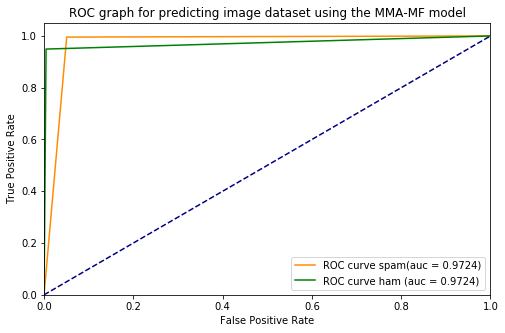

Epoch 1/30
4800/4800 [==============================] - 371s 77ms/step - loss: 0.1700 - acc: 0.9460
Epoch 2/30
4800/4800 [==============================] - 366s 76ms/step - loss: 0.0201 - acc: 0.9944
Epoch 3/30
4800/4800 [==============================] - 369s 77ms/step - loss: 0.0088 - acc: 0.9983
Epoch 4/30
4800/4800 [==============================] - 367s 76ms/step - loss: 0.0016 - acc: 0.9996
Epoch 5/30
4800/4800 [==============================] - 363s 76ms/step - loss: 8.6412e-04 - acc: 1.0000
Epoch 6/30
4800/4800 [==============================] - 368s 77ms/step - loss: 6.6353e-04 - acc: 0.9998
Epoch 7/30
4800/4800 [==============================] - 371s 77ms/step - loss: 1.8419e-04 - acc: 1.0000
Epoch 8/30
4800/4800 [==============================] - 369s 77ms/step - loss: 1.0347e-04 - acc: 1.0000
Epoch 9/30
4800/4800 [==============================] - 369s 77ms/step - loss: 8.1566e-05 - acc: 1.0000
Epoch 10/30
4800/4800 [==============================] - 360s 75ms/step - loss: 

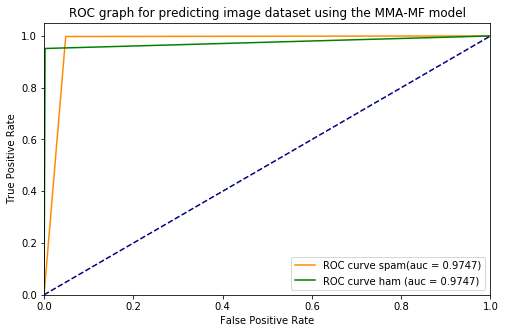

Epoch 1/30
4800/4800 [==============================] - 290s 60ms/step - loss: 0.1849 - acc: 0.9358
Epoch 2/30
4800/4800 [==============================] - 286s 60ms/step - loss: 0.0194 - acc: 0.9952
Epoch 3/30
4800/4800 [==============================] - 286s 60ms/step - loss: 0.0075 - acc: 0.9988
Epoch 4/30
4800/4800 [==============================] - 286s 60ms/step - loss: 0.0035 - acc: 0.9994
Epoch 5/30
4800/4800 [==============================] - 300s 63ms/step - loss: 0.0014 - acc: 0.9998
Epoch 6/30
4800/4800 [==============================] - 302s 63ms/step - loss: 3.8242e-04 - acc: 1.0000
Epoch 7/30
4800/4800 [==============================] - 302s 63ms/step - loss: 1.7906e-04 - acc: 1.0000
Epoch 8/30
4800/4800 [==============================] - 301s 63ms/step - loss: 1.7958e-04 - acc: 1.0000
Epoch 9/30
4800/4800 [==============================] - 302s 63ms/step - loss: 8.4021e-05 - acc: 1.0000
Epoch 10/30
4800/4800 [==============================] - 299s 62ms/step - loss: 6.25

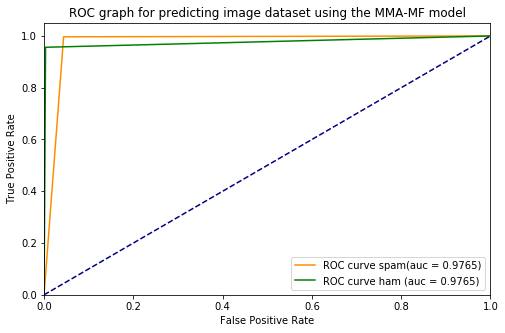

Epoch 1/30
4800/4800 [==============================] - 298s 62ms/step - loss: 0.1890 - acc: 0.9373
Epoch 2/30
4800/4800 [==============================] - 294s 61ms/step - loss: 0.0288 - acc: 0.9940
Epoch 3/30
4800/4800 [==============================] - 292s 61ms/step - loss: 0.0126 - acc: 0.9973
Epoch 4/30
4800/4800 [==============================] - 292s 61ms/step - loss: 0.0074 - acc: 0.9975
Epoch 5/30
4800/4800 [==============================] - 292s 61ms/step - loss: 0.0015 - acc: 0.9994
Epoch 6/30
4800/4800 [==============================] - 292s 61ms/step - loss: 5.2866e-04 - acc: 1.0000
Epoch 7/30
4800/4800 [==============================] - 292s 61ms/step - loss: 1.9137e-04 - acc: 1.0000
Epoch 8/30
4800/4800 [==============================] - 292s 61ms/step - loss: 1.2651e-04 - acc: 1.0000
Epoch 9/30
4800/4800 [==============================] - 291s 61ms/step - loss: 1.0450e-04 - acc: 1.0000
Epoch 10/30
4800/4800 [==============================] - 291s 61ms/step - loss: 0.01

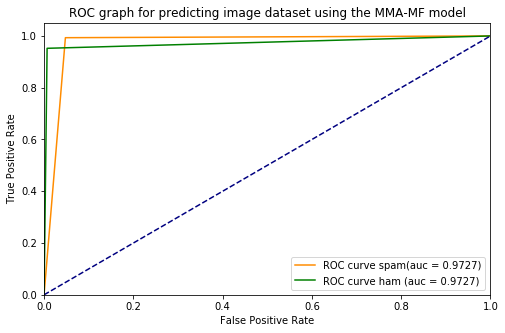

Epoch 1/30
4800/4800 [==============================] - 199s 42ms/step - loss: 0.1850 - acc: 0.9346
Epoch 2/30
4800/4800 [==============================] - 197s 41ms/step - loss: 0.0246 - acc: 0.9931
Epoch 3/30
4800/4800 [==============================] - 197s 41ms/step - loss: 0.0051 - acc: 0.9985
Epoch 4/30
4800/4800 [==============================] - 198s 41ms/step - loss: 0.0048 - acc: 0.9983
Epoch 5/30
4800/4800 [==============================] - 203s 42ms/step - loss: 0.0011 - acc: 0.9998
Epoch 6/30
4800/4800 [==============================] - 203s 42ms/step - loss: 4.7813e-04 - acc: 1.0000
Epoch 7/30
4800/4800 [==============================] - 203s 42ms/step - loss: 2.0259e-04 - acc: 1.0000
Epoch 8/30
4800/4800 [==============================] - 203s 42ms/step - loss: 3.0084e-04 - acc: 0.9998
Epoch 9/30
4800/4800 [==============================] - 203s 42ms/step - loss: 0.0015 - acc: 0.9994
Epoch 10/30
4800/4800 [==============================] - 201s 42ms/step - loss: 2.6121e-

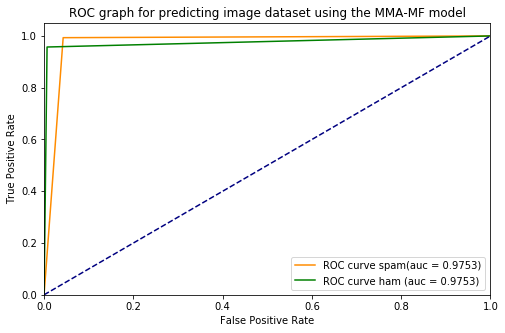

***************************Accuracy****************************
The all of acc score:  [98.41666666666666, 98.66666666666667, 98.66666666666667, 98.25, 98.41666666666666]
The average score: 98.48% (+/- 0.16%)
---------------------------F1-Score-----------------------------
The all of f1_scores score:  [0.9784262314316561, 0.9815036742180485, 0.9818960835194013, 0.9771415924146369, 0.9789123001408622]
The average score: 0.98% (+/- 0.00%)
+++++++++++++++++++++++++++Recall-Score+++++++++++++++++++++++++
The average score: 0.97% (+/- 0.00%)


In [4]:
# use GPU block
# 随机数设置，便于产生相同的随机数
seed = 42
np.random.seed(seed)

# 定义 K-fold 交叉验证 参数
kfold= KFold(n_splits=5, shuffle=True, random_state=seed)
n_classes=2
flag=1
f1_scores=[]
recall_scores=[]
cvscores=[]
for train, test in kfold.split(x_train, y_train):
    # Cross validation 交叉验证结果
   
    model = Sequential()
    model.add(Embedding(len(word_index)+1,300,input_length=MAX_SEQUENCE_LENGTH))
    # model.add(Embedding(len(vocab)+1, 300, input_length=20))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.1,return_sequences=True))
    model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.1))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    #model.summary()
    #model.fit(x_train, y_train, batch_size=32,epochs=20,validation_data=(x_val,y_val))
    #model.save("lstm_final.h5")
    
    model.fit(x_train[train], y_train[train], epochs=30, batch_size=32, verbose=1)
    model.save("/home/aqts/yangHong/first-spam-experiment/h5_model/text_lstm_model_k_flod"+str(flag)+".h5")
    # 评估模型
    # accuracy
    scores = model.evaluate(x_train[test], y_train[test], verbose=0)
#     print("%s: %s %.2f%%" % (model.metrics_names[1], ':', scores[1]*100))
    cvscores.append(scores[1]*100)
    y_pred_score=y_pred=model.predict(x_train[test], 32)
    #get precision
    for i in range(len(y_pred)):
        if(y_pred[i][0]>0.5):
            y_pred[i][0]=1
        else:
            y_pred[i][0]=0
        if(y_pred[i][1]>0.5):
            y_pred[i][1]=1
        else:
            y_pred[i][1]=0
    print("---------------------------Precision-----------------------------")
    print(classification_report(y_train[test],y_pred))
    #f1-score
    f1_scores.append(f1_score(y_train[test],y_pred,average = 'macro'))
    #recall-score
    recall_scores.append(recall_score(y_train[test],y_pred,average = 'macro'))
    #get auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train[test][:, i], y_pred_score[:, i])    
        roc_auc[i] = auc(fpr[i], tpr[i])   

    # #Plot of a ROC curve for a specific class
    plt.rcParams['figure.figsize']=(8,5)
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve spam(auc = %0.4f)' % roc_auc[1])
    plt.plot(fpr[0], tpr[0], color='green', label='ROC curve ham (auc = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC graph for predicting image dataset using the MMA-MF model')
    plt.legend(loc="lower right")
    plt.savefig("/home/aqts/yangHong/first-spam-experiment/experiment_result_roc/ROC_graph_for_Text"+str(flag)+".png")
    plt.show()
    flag=flag+1
print("***************************Accuracy****************************")
print("The all of acc score: " ,(cvscores))
print("The average score: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("---------------------------F1-Score-----------------------------")
print("The all of f1_scores score: " ,(f1_scores))
print("The average score: %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))
print("+++++++++++++++++++++++++++Recall-Score+++++++++++++++++++++++++")
print("The average score: %.2f%% (+/- %.2f%%)" % (np.mean(recall_scores), np.std(recall_scores)))

In [11]:
print("***************************Accuracy****************************")
print("The all of acc score: " ,(cvscores))
print("The average score: %.4f%% (+/- %.4f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("---------------------------F1-Score-----------------------------")
print("The all of f1_scores score: " ,(f1_scores))
print("The average score: %.4f%% (+/- %.4f%%)" % (np.mean(f1_scores), np.std(f1_scores)))
print("+++++++++++++++++++++++++++Recall-Score+++++++++++++++++++++++++")
print("The all of f1_scores score: " ,(recall_scores))
print("The average score: %.4f%% (+/- %.4f%%)" % (np.mean(recall_scores), np.std(recall_scores)))

***************************Accuracy****************************
The all of acc score:  [98.41666666666666, 98.66666666666667, 98.66666666666667, 98.25, 98.41666666666666]
The average score: 98.4833% (+/- 0.1616%)
---------------------------F1-Score-----------------------------
The all of f1_scores score:  [0.9784262314316561, 0.9815036742180485, 0.9818960835194013, 0.9771415924146369, 0.9789123001408622]
The average score: 0.9796% (+/- 0.0018%)
+++++++++++++++++++++++++++Recall-Score+++++++++++++++++++++++++
The all of f1_scores score:  [0.9724497727816312, 0.9746808518719685, 0.9764533485463718, 0.972728645166856, 0.9752702067669172]
The average score: 0.9743% (+/- 0.0015%)
